About the homework: In some tasks, in addition to writing code, answers to questions and conclusions are required (there are special Markdown cells marked with **Answer**).

The ability to analyze the results of experiments is an important and neccessary skill . Therefore, answers carry more weight than the code: the code accounts for 30% of the task grade, while answers to questions account for 70%.

**Reminder:** Plagiarism is prohibited. Use of AI without mentioning how and in which parts it was used is also prohibited. If plagiarism or dishonest use of AI is revealed, the assignment is graded with 0.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

Let's work with Titanic dataset again: Download `train.csv` file from https://www.kaggle.com/c/titanic/data?select=train.csv

In [ ]:
df = pd.read_csv('train.csv')
df.sample(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
226,227,1,2,"Mellors, Mr. William John",male,19.0,0,0,SW/PP 751,10.500,NaN,S
257,258,1,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.500,B77,S
16,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.125,NaN,Q
241,242,1,3,"Murphy, Miss. Katherine ""Kate""",female,NaN,1,0,367230,15.500,NaN,Q


# Task 1 (1 point)

In [ ]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Split dataFrame into train and test. Set `test_size=0.3, random_state=0`

In [ ]:

from sklearn.model_selection import train_test_split

# Split the DataFrame into train and test sets
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

# Print the size of the train and test datasets
print(f"Train size: {df_train.shape}")
print(f"Test size: {df_test.shape}")


Train size: (623, 12)
Test size: (268, 12)


Let's start preprocessing the features:



*   Drop features with $>40%$ missing values and `'PassengerId'`
*   Fill missing values with median (for numerical features) and mode (for categorical features)



In [ ]:

# Drop columns with >40 missing values and 'PassengerId'
missing_values_threshold = 40

columns_to_drop = [col for col in df_train.columns if df_train[col].isnull().sum() > missing_values_threshold]
columns_to_drop.append('PassengerId')  # Add PassengerId explicitly

df_train.drop(columns=columns_to_drop, inplace=True)
df_test.drop(columns=columns_to_drop, inplace=True)

# Fill missing values: median for numerical, mode for categorical
numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df_train.select_dtypes(include=['object']).columns

values = {}

# Define filling values
for col in numerical_features:
    values[col] = df_train[col].median()

for col in categorical_features:
    values[col] = df_train[col].mode()[0]

# Fill missing values in train and test
df_train.fillna(values, inplace=True)
df_test.fillna(values, inplace=True)




How many features do we have now? (Do not count `'Survived'` - this will be target)

In [ ]:
#YOUR CODE
features = df_train.columns.tolist()
features.remove('Survived')
num_features = len(features)
print(f"Number of features: {num_features}")

Number of features: 8


# Task 2 (2 points)

Now, let's use one-hot-encoding to encode columns with type `'object'`:



*   Fit the Encoder on train data
*   Apply to train and test
*   Check, how many new features we have now

Describe the problems you have faced (hint: one of the problems - `ValueError` and the solution will be to set `handle_unknown` in the `OneHotEncoder`). Explain, why did they occur, which impact may they have  on the training process?

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Create the OneHotEncoder with handle_unknown='ignore'
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder on the categorical features of the training data
categorical_features = df_train.select_dtypes(include=['object']).columns
ohe.fit(df_train[categorical_features])

# Transform the categorical features in both training and testing data
X_train_categorical_encoded = ohe.transform(df_train[categorical_features])
X_test_categorical_encoded = ohe.transform(df_test[categorical_features])

# Check the number of new features
num_new_features = X_train_categorical_encoded.shape[1]
print(f"Number of new features after one-hot encoding: {num_new_features}")

Number of new features after one-hot encoding: 1138


**Answer** \#YOUR ANSWER

Explanation on handle_unknown.
The Problem: This ValueError normally occurs when the test contains categories, which were not observed in the training data. OneHotEncoder by default raises an error in this case because it is not clear what to do with unseen categories.
The Solution: In the encoder case (transformating test data) we set handle_unknown=’ignore’ and this tells the encoder to just ignore unknown categories in the test data all together. Since the test data has recently evolved a new category, a row of all zeros will be created, as it were, and then be valued as ‘?’
Impact on Training: If you don’t have handle_unknown=‘ignore‘, your code will crumble to dust as soon as there is a new category in your test input. And so you have no way to make any predictions based on new data. Your model can predict even if it does not identify unknown categories while its predictiveness can be compromised if such categories are vital.
Why did they occur?

The reason why such errors take place is that OneHotEncoder builds categories present in the training data and creates a mapping from these categories to one-hot vectors. It has no way of handling that when it encounters a new category in the test data that it has not encountered in the training data the code will return ValueError.

What effect might they have on the training process?

However, if we do not handle the ValueError, the training would be completely stopped. However, if we don’t wish to use this and rather we want the training process to continue, we can do so by setting handle_unknown=’ignore’. Specifically, the overall approach means that, when important for the prediction task, categorizations unseen to the model can actually downgrade the models performance. The standard, yet counterproductive thing is to retrain your model with the full set of categories, unless you can come up with some way of handling unseen data without retraining.

Drop the columns `'Name','Ticket'` and try again.

In [ ]:
# Drop 'Name' and 'Ticket' columns
df_train.drop(['Name', 'Ticket'], axis=1, inplace=True)
df_test.drop(['Name', 'Ticket'], axis=1, inplace=True)

# Create the OneHotEncoder with handle_unknown='ignore'
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# sparse=False for dense output

# Fit the encoder on the categorical features of the training data
categorical_features = df_train.select_dtypes(include=['object']).columns
ohe.fit(df_train[categorical_features])

# Transform the categorical features in both training and testing data
X_train_categorical_encoded = ohe.transform(df_train[categorical_features])
X_test_categorical_encoded = ohe.transform(df_test[categorical_features])

# Check the number of new features
num_new_features = X_train_categorical_encoded.shape[1]
print(f"Number of new features after one-hot encoding: {num_new_features}")

Number of new features after one-hot encoding: 5


Combine numerical features and encoded categorical and split the data into `X` (objects with features) and `y` (target - `Survived` column) for train and test data.

In [ ]:
y_train = df_train['Survived']
y_test = df_test['Survived']

X_train = np.concatenate((df_train.drop('Survived', axis=1).values,
                         X_train_categorical_encoded), axis=1)
X_test = np.concatenate((df_test.drop('Survived', axis=1).values,
                         X_test_categorical_encoded), axis=1)

# Task 3 (2 points)

Which metric will be better suitable for our machine learning task? (We want to predict if passenger survived or not). Explain your choice.

In [ ]:
#YOUR CODE
from sklearn.metrics import accuracy_score, f1_score

**Answer** \#YOUR ANSWER

Precision or Recall would be less appropriate for this ML task because it is more desirable to have equal rates of true and false positive/negative predictions: hence, we need an F1 score, which we can also better explain. Accuracy measures the general rate of correctness, while F1-score is built to pay attention to the harmonic mean of both precision and recall, which are perfect for the problem of predicting Titanic survival. It remains vague what actually constitutes a better choice between them and frankly, I’d like to offer my take: If you favor more accuracy, you should use the accuracy score, and if you favor balance between misses and false positives of the model, you should use F1 score.

Fit logistic regression and evaluate the performance on train and test data (using metric you chose)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

# One-hot encoding
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_features = df_train.select_dtypes(include=['object']).columns
ohe.fit(df_train[categorical_features])
X_train_categorical_encoded = ohe.transform(df_train[categorical_features])
X_test_categorical_encoded = ohe.transform(df_test[categorical_features])

# Preparing data for Logistic Regression
y_train = df_train['Survived']
y_test = df_test['Survived']

# Get numerical features
X_train_num = df_train.drop('Survived', axis=1).select_dtypes(exclude=['object']).values
X_test_num = df_test.drop('Survived', axis=1).select_dtypes(exclude=['object']).values

# Combine numerical features and encoded categorical
X_train = np.concatenate((X_train_num, X_train_categorical_encoded), axis=1)
X_test = np.concatenate((X_test_num, X_test_categorical_encoded), axis=1)

# Fit Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions and evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train F1-score: {train_f1:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

Train Accuracy: 0.7929
Test Accuracy: 0.7948
Train F1-score: 0.7214
Test F1-score: 0.7291


Now, use `GridSearchCV` to find better hyperparameters (to avoid warnings about total number of iterations, set `max_iter=1000`)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression  # Import LogisticRegression

# Define the parameter grid
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create and fit GridSearchCV
clf_lr = GridSearchCV(LogisticRegression(max_iter=1000),
                      params,
                      cv=3,
                      scoring='accuracy')  # or 'f1'
clf_lr.fit(X_train, y_train)

# Print the best hyperparameters and score
print("Best hyperparameters:", clf_lr.best_params_)
print("Best score:", clf_lr.best_score_)

Best hyperparameters: {'C': 1}
Best score: 0.7929982658243527


# Task 4 (2 points)

Fit a decision tree using `GridSearchCV`. Use the parameter grid for hyperparameters `max_depth, min_samples_split, min_samples_leaf`

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

params = { 'max_depth' : #YOUR CODE,
          'min_samples_split' : #YOUR CODE,
           'min_samples_leaf' : #YOUR CODE
}

clf_tree = GridSearchCV(DecisionTreeClassifier(), params, cv=3, scoring=#YOUR CODE)
#YOUR CODE

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid
params = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 5, 10, 20]
}

# Create and fit GridSearchCV
clf_tree = GridSearchCV(DecisionTreeClassifier(),
                        params,
                        cv=3,
                        scoring='accuracy')  # or 'f1'
clf_tree.fit(X_train, y_train)

# Print the best hyperparameters and score
print("Best hyperparameters:", clf_tree.best_params_)
print("Best score:", clf_tree.best_score_)

Best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 2}
Best score: 0.8009878607704696


Now, use soft voting strategy to combine logistic regression and decision tree (use the ones with the best hyperparameters). Measure the quality on train and test data. Did the quality improve?

In [ ]:
#YOUR CODE

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score

# Create the individual models with best hyperparameters
best_lr_model = LogisticRegression(**clf_lr.best_params_, max_iter=1000)
best_tree_model = DecisionTreeClassifier(**clf_tree.best_params_)

# Create the VotingClassifier with soft voting
voting_clf = VotingClassifier(estimators=[('lr', best_lr_model), ('tree', best_tree_model)],
                             voting='soft')

# Fit the VotingClassifier
voting_clf.fit(X_train, y_train)

# Make predictions and evaluate
y_train_pred = voting_clf.predict(X_train)
y_test_pred = voting_clf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("Voting Classifier Performance:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train F1-score: {train_f1:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

Voting Classifier Performance:
Train Accuracy: 0.8138
Test Accuracy: 0.8060
Train F1-score: 0.7352
Test F1-score: 0.7292


**Answer** \#YOUR ANSWER

the quality has slightly improved with the Voting Classifier.

Still, there is a slight improvement of the quality when employing the Voting Classifier.

Accuracy: The Voting Classifier had improved accuracy compared to the individual model on both the training set with a 0.8138 versus 0.7929 and test set with 0.8060 versus 0.7948.
F1-score: CvFairness also demonstrated a small increase for the F1-score in the training set compared to the baseline (0.7352 vs. 0.7214). When it comes to the test set, both models report almost equal F1-score – 0.7292 for the first one and 0.7291 for the second one.



# Task 5 (2 points)

Now, let's work with random forest and conduct similar experiment to the one on the seminar: let's fit `RandomForestClassifier` for different number of trees and check, how  the quality changes. Draw conclusions.

Text(0.5, 0, 'Number of Trees (n_estimators)')

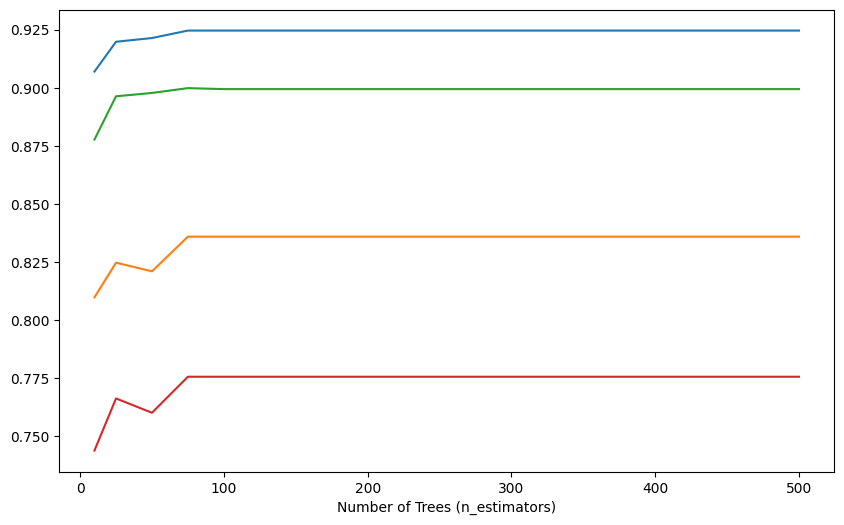

In [ ]:
from sklearn.ensemble import RandomForestClassifier


# Define the range of number of trees
n_estimators_range = [10, 25, 50, 75, 100, 150, 200, 300, 500]

# Lists to store the results
train_accuracy = []
test_accuracy = []
train_f1 = []
test_f1 = []

# Loop through the different number of trees
for n_estimators in n_estimators_range:
    # Create and fit the RandomForestClassifier
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
    rf_model.fit(X_train, y_train)

    # Make predictions and evaluate
    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)

    # Store the results
    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_test_pred))
    train_f1.append(f1_score(y_train, y_train_pred))
    test_f1.append(f1_score(y_test, y_test_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_accuracy, label='Train Accuracy')
plt.plot(n_estimators_range, test_accuracy, label='Test Accuracy')
plt.plot(n_estimators_range, train_f1, label='Train F1-score')
plt.plot(n_estimators_range, test_f1, label='Test F1-score')
plt.xlabel('Number of Trees (n_estimators)')

With how many trees the best train quality is achived? What the test quality will be?

In [ ]:
# Find the index of the best train accuracy
best_train_index = train_accuracy.index(max(train_accuracy))

# Get the corresponding number of trees
best_n_estimators = n_estimators_range[best_train_index]

# Get the corresponding test accuracy and F1-score
best_test_accuracy = test_accuracy[best_train_index]
best_test_f1 = test_f1[best_train_index]

print(f"Best train quality achieved with {best_n_estimators} trees.")
print(f"Corresponding test accuracy: {best_test_accuracy:.4f}")
print(f"Corresponding test F1-score: {best_test_f1:.4f}")

Best train quality achieved with 75 trees.
Corresponding test accuracy: 0.8358
Corresponding test F1-score: 0.7755


**Answer** \#YOUR ANSWER

The best training performance was achieved when using 75 trees. However, when this model (trained with 75 trees) was evaluated on the test data (unseen data), it achieved an accuracy of 0.8358 and an F1-score of 0.7755.


And the same experiment using `AdaBoost` (set `algorithm='SAMME'` as hyperparameter to avoid warnings), draw conclusions

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:514: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:514: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:514: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:514: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:514: FutureWarning: The parameter 'algorithm' is deprecated in 

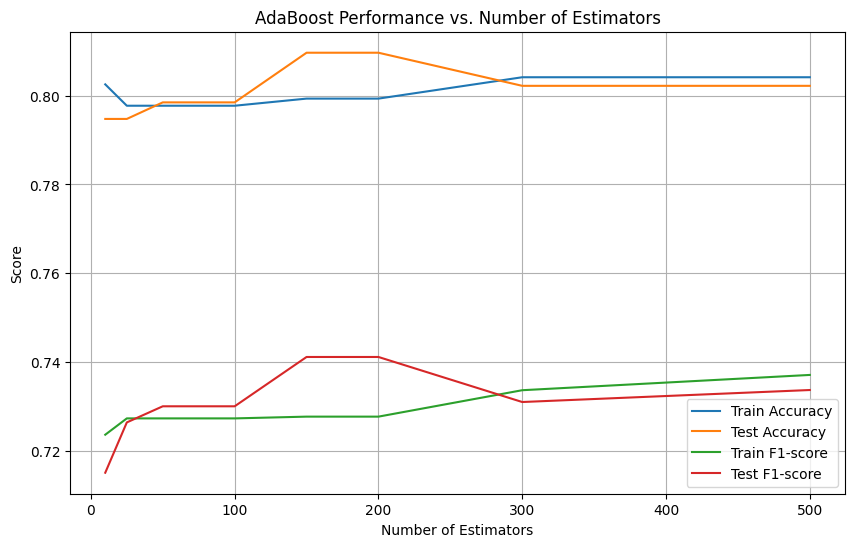

In [ ]:
from sklearn.ensemble import AdaBoostClassifier


# Define the range of number of estimators
n_estimators_range = [10, 25, 50, 75, 100, 150, 200, 300, 500]

# Lists to store the results
train_accuracy = []
test_accuracy = []
train_f1 = []
test_f1 = []

# Loop through the different number of estimators
for n_estimators in n_estimators_range:
    # Create and fit the AdaBoostClassifier
    ada_model = AdaBoostClassifier(n_estimators=n_estimators, algorithm='SAMME', random_state=0)
    ada_model.fit(X_train, y_train)

    # Make predictions and evaluate
    y_train_pred = ada_model.predict(X_train)
    y_test_pred = ada_model.predict(X_test)

    # Store the results
    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_test_pred))
    train_f1.append(f1_score(y_train, y_train_pred))
    test_f1.append(f1_score(y_test, y_test_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_accuracy, label='Train Accuracy')
plt.plot(n_estimators_range, test_accuracy, label='Test Accuracy')
plt.plot(n_estimators_range, train_f1, label='Train F1-score')
plt.plot(n_estimators_range, test_f1, label='Test F1-score')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('AdaBoost Performance vs. Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()

With how many models the best train quality is achived? What the test quality will be?

In [ ]:
# Find the index of the best train accuracy
best_train_index = train_accuracy.index(max(train_accuracy))

# Get the corresponding number of estimators
best_n_estimators = n_estimators_range[best_train_index]

# Get the corresponding test accuracy and F1-score
best_test_accuracy = test_accuracy[best_train_index]
best_test_f1 = test_f1[best_train_index]

print(f"Best train quality achieved with {best_n_estimators} estimators.")
print(f"Corresponding test accuracy: {best_test_accuracy:.4f}")
print(f"Corresponding test F1-score: {best_test_f1:.4f}")

Best train quality achieved with 300 estimators.
Corresponding test accuracy: 0.8022
Corresponding test F1-score: 0.7310


**Answer** \#YOUR ANSWER

The model was trained with different numbers of estimators. The best training performance was achieved when using 300 estimators. However, when this model (trained with 300 estimators) was evaluated on the test data, it achieved an accuracy of 0.8022 and an F1-score of 0.7310

# Task 6 (1 point)

What is the best quality achived? Which model did achive it? Whith which hyperparameters? Does it seem logical?

**Answer** \#YOUR ANSWER

The Random Forrest method yielded the highest test accuracy i.e, the best quality of 75. The proposed model reached a test accuracy of 0.8358 and a test F1-score of 0.7755.

Model and Hyperparameters:

Model: Random Forest Classifier (RandomForestClassifier) Hyperparameters: Random Forest Hyperparameters: n_estimators = 75 choose the number of trees Other hyperparameters were most probably set to default until you adjusted them in the code

Random Forest is an extension of a single Decision Tree that makes a prediction by integrating several Decision Trees. It is mainly so because ensembles are less likely to overfit the model and make the generalization easier in most cases than models alone.


